#### An automobile company has plans to enter new markets with their existing products. 
#### After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.

#### In their existing market, the sales team has classified all customers into 2 segments High Quality Customers and Low Quality Customers. 
#### Then, they performed segmented outreach and communication for a different segment of customers. 
#### This strategy has work exceptionally well for them. They plan to use the same strategy for the new markets and have identified 2627 new potential customers.

#### The task is to predict the right group of the new customers.

# ----------------------------------------------------------------------

#### Modules and datasets are imported.

In [103]:
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings

# Ignore specific type of warning
warnings.filterwarnings("ignore")

# Load the data
data = pd.read_excel('Customer_Database.xlsx')
new_data = pd.read_excel('Potential_New_Customers.xlsx')

target_new_data = new_data['Segmentation']
new_data['Segmentation'] = "Pending"

full_data = pd.concat([data, new_data])

### Data Cleansing: Full dataset

##### Missing values check:

In [104]:
full_data.isnull().sum()

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64

##### Categorical non-binary variables are converted into dummy variables:

In [105]:
full_data['Profession'][full_data['Profession'].isnull()] = "Other"
full_data['Var_1'][full_data['Var_1'].isnull()] = "Missing_cat"

dummies = ['Profession', 'Var_1', 'Spending_Score']

for dum in dummies:
    encoded_variables = pd.get_dummies(full_data[dum], prefix=dum + '_')
    full_data = pd.concat([full_data, encoded_variables], axis=1)
    full_data.drop(dum, axis=1, inplace=True)

##### Binary variables are encoded. Work experience missing values are completed with 0 years of experience.

In [106]:
# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
categorical_cols = ['Gender']
for col in categorical_cols:
    full_data[col] = label_encoder.fit_transform(full_data[col])

binomial_cols = ['Ever_Married', 'Graduated']
for col in binomial_cols:
    full_data[col].fillna(-1, inplace=True)
    # Map the values to numeric values
    dict_mapping = {'No': 0, 'Yes': 1, -1: None}
    full_data[col] = full_data[col].astype(str)
    full_data[col] = full_data[col].map(dict_mapping)

full_data['Work_Experience'].fillna(0, inplace=True)

##### The missing values of 'Graduated' attribute are filled using Random Forest Classifier:

In [107]:
#################### Graduated attribute #######################

# Split data into training and potencial customers sets
train_gr = full_data[full_data['Graduated'].notnull()]
test_gr = full_data[full_data['Graduated'].isnull()]

# Define features and target variable
features = []

# Iterate through column names
for column in train_gr.columns:
    if column.startswith(('Profession_')):
        features.append(column)
    elif column in ['Age', 'Gender', 'Work_Experience']:
        features.append(column)

X_gr = train_gr[features]
y_gr = train_gr['Graduated']


# Initialize the classification model
gr_model = RandomForestClassifier(n_estimators = 100,
                                       max_depth = 10,
                                       min_samples_leaf = 4,
                                       min_samples_split = 2,
                                       class_weight = {0: 1, 1: 1.3}
                                       )

gr_model.fit(X_gr, y_gr)

# Potencial Customers features
X_test_gr = test_gr[features]

# Predict missing values
predicted_values_gr = gr_model.predict(X_test_gr)

# Fill missing values in the test set
test_gr['Graduated'] = predicted_values_gr

# Concatenate train and test sets back together
filled_data = pd.concat([train_gr, test_gr])

#### The missing values of 'Ever_Married' attribute is filled using Random Forest Classifier:

In [108]:
#################### Ever_Married attribute #######################

# Split data into training and test sets
train_em = filled_data[filled_data['Ever_Married'].notnull()]
test_em = filled_data[filled_data['Ever_Married'].isnull()]


# Define features and target variable
features = []

# Iterate through column names
for column in train_em.columns:
    if column.startswith(('Profession_')):
        features.append(column)
    elif column in ['Age', 'Gender', 'Work_Experience']:
        features.append(column)

X_em = train_em[features]
y_em = train_em['Ever_Married']


# Initialize the classification model
em_model = RandomForestClassifier(n_estimators = 100,
                                       max_depth = 10,
                                       min_samples_leaf = 4,
                                       min_samples_split = 2,
                                       class_weight = {0: 1, 1: 1.3}
                                       )

em_model.fit(X_em, y_em)

# Potencial Customers features
X_test_em = test_em[features]

# Predict missing values
predicted_values_em = em_model.predict(X_test_em)

# Fill missing values in the test set
test_em['Ever_Married'] = predicted_values_em

# Concatenate train and test sets back together
filled_data = pd.concat([train_em, test_em])

#### Family_Size attribute is filled using the average, grouping by 'Graduated', 'Gender' and 'Ever_Married' atrributes. Also, a new variable is created --> 'work_age_ratio'

In [109]:
# Fill missing values in 'Family_Size' with appropriate values
filled_data['Family_Size'] = filled_data['Family_Size'].fillna(filled_data.groupby(['Graduated', 'Gender', 'Ever_Married'])['Family_Size'].transform('mean'))

# New features
filled_data['work_age_ratio'] = filled_data['Work_Experience']/filled_data['Age']

#### Now that all the data has been cleaned, I split the dataset into current customers and potencial customers.

In [110]:
customers = filled_data[filled_data['Segmentation']!='Pending']
potencial_customers = filled_data[filled_data['Segmentation']=='Pending']
print(customers.shape)
print(potencial_customers.shape)

(8068, 30)
(2627, 30)


## Training the model: 
### 1- Split Customer database into Training and Testing

#### It is important to check if the data is balanced or imbalanced. As it is shown below, the dataset is balanced in terms of the target variable 'Segmentation'.

In [111]:
customers['Segmentation'].value_counts()

Segmentation
LQC    4238
HQC    3830
Name: count, dtype: int64

### 2- A Classification model is trained and its performance is tested.

In [112]:
# Define features and target variable
features = [col for col in customers.columns if (col != 'Segmentation') and (col != 'ID')]
target = 'Segmentation'

X = customers[features]
y = customers[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

#### 2.1- Random Forest Classifier Algorithm

In [113]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

##### 2.1.1- Hyperparameter Tuning and Fiting the model (using all features)

In [114]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}


##### 2.1.2- Predictions and model performance

              precision    recall  f1-score   support

         HQC       0.67      0.72      0.69       781
         LQC       0.72      0.66      0.69       833

    accuracy                           0.69      1614
   macro avg       0.69      0.69      0.69      1614
weighted avg       0.69      0.69      0.69      1614



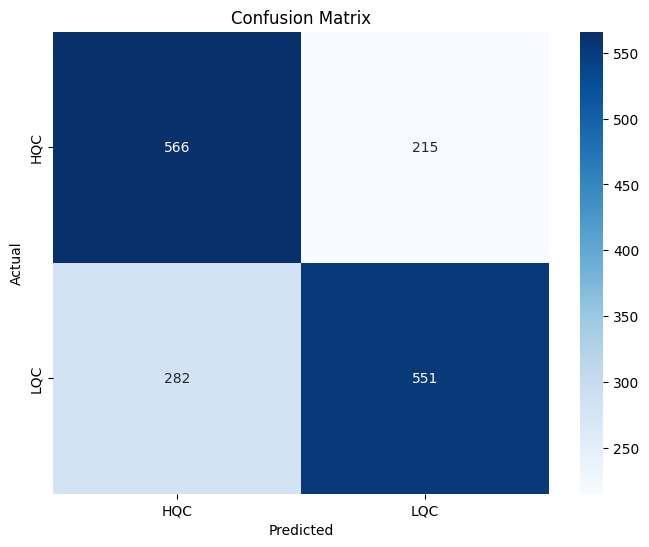

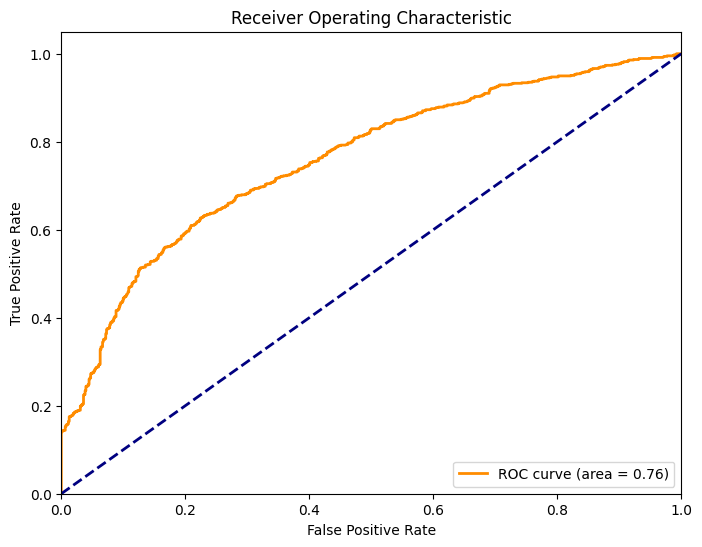

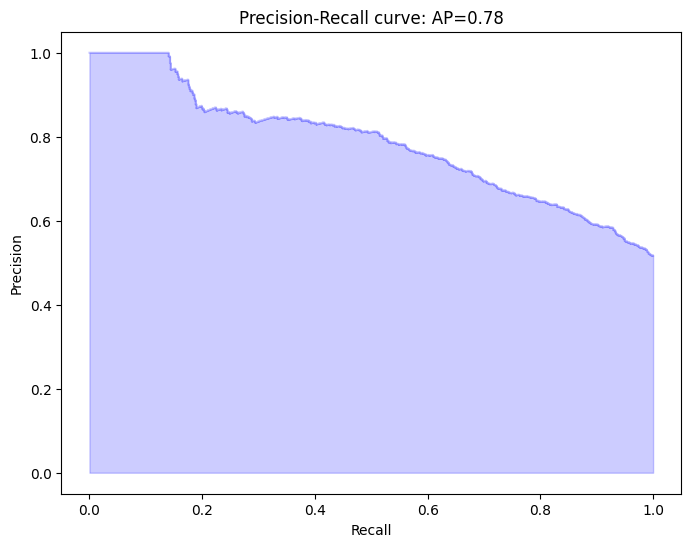

In [115]:
# Make predictions using the best model
y_pred = best_rf_model.predict(X_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert target labels to numeric
label_encoder = LabelEncoder()
y_val_numeric = label_encoder.fit_transform(y_val)

# Convert predicted labels to numeric
y_pred_numeric = label_encoder.transform(y_pred)

# Plot ROC Curve
y_score = best_rf_model.predict_proba(X_val)
fpr, tpr, _ = roc_curve(y_val_numeric, y_score[:, 1])  
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_numeric, y_score[:, 1])  # Use y_val_numeric
avg_precision = average_precision_score(y_val_numeric, y_score[:, 1])  # Use y_val_numeric
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(avg_precision))
plt.show()

#### 2.2- XGBoost Classifier Algorithm

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       770
           1       0.70      0.68      0.69       844

    accuracy                           0.68      1614
   macro avg       0.68      0.68      0.68      1614
weighted avg       0.68      0.68      0.68      1614



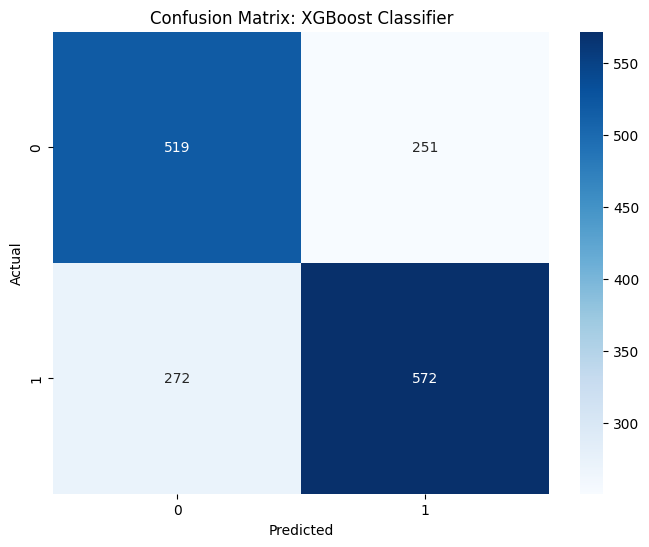

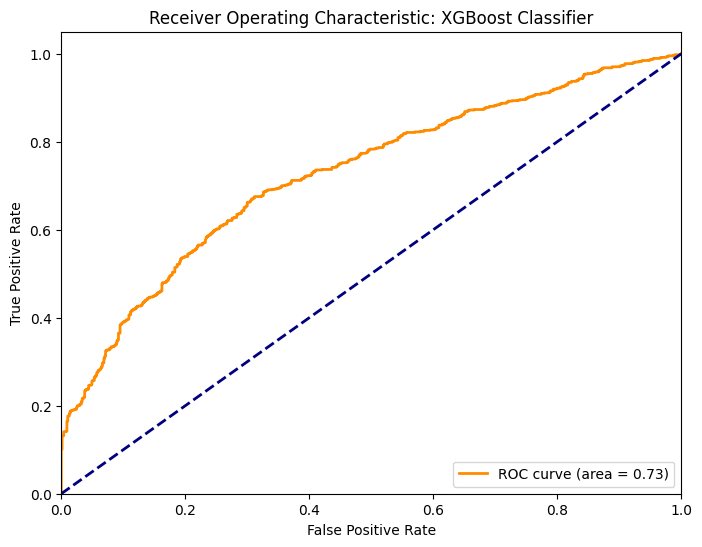

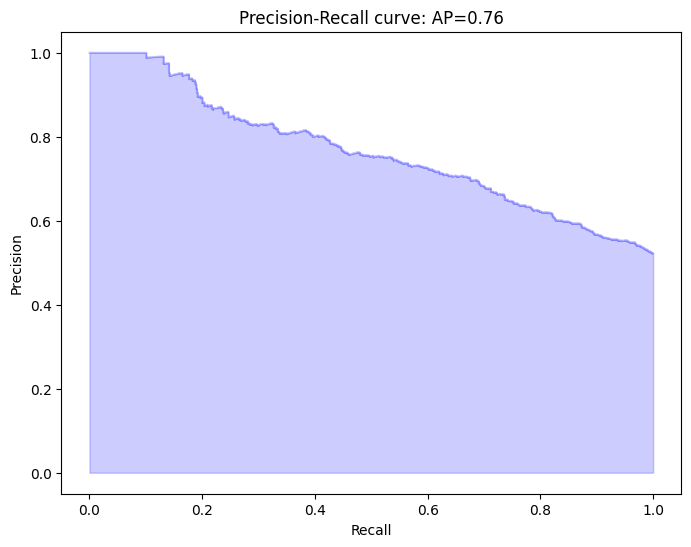

In [116]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

X = customers[features]
y = customers[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Fit the model to the training data
xgb_model.fit(X_train, y_train_encoded)

# Make predictions on the validation set
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate the XGBoost model
print("XGBoost Classification Report:")
print(classification_report(y_val_encoded, y_pred_xgb))

# Calculate the confusion matrix
cm3 = confusion_matrix(y_val_encoded, y_pred_xgb)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGBoost Classifier')
plt.show()

# Get predicted probabilities for positive class
y_scores_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val_encoded, y_scores_xgb)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic: XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_encoded, y_scores_xgb)
avg_precision = average_precision_score(y_val_encoded, y_scores_xgb)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(avg_precision))
plt.show()

#### 2.3- K-Nearest Neighbours

0.5973921019063395
k-Nearest Neighbors (KNN) Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       770
           1       0.66      0.64      0.65       844

    accuracy                           0.64      1614
   macro avg       0.64      0.64      0.64      1614
weighted avg       0.64      0.64      0.64      1614



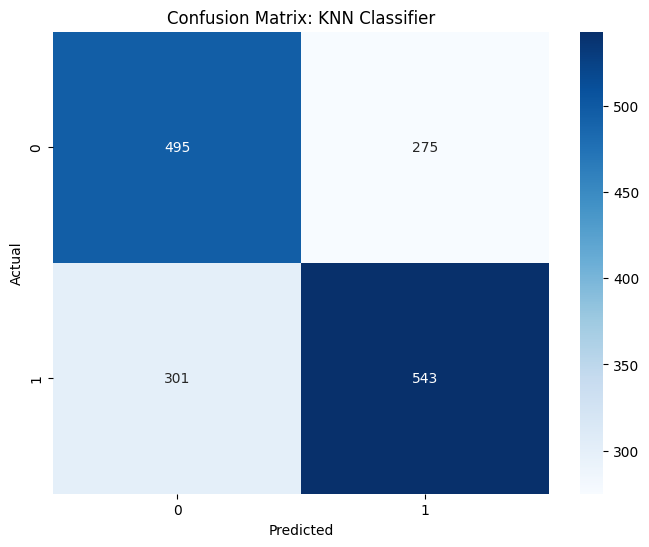

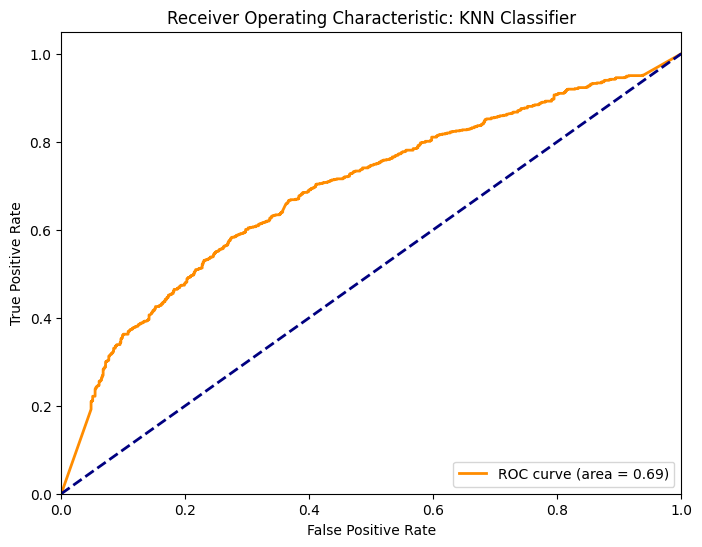

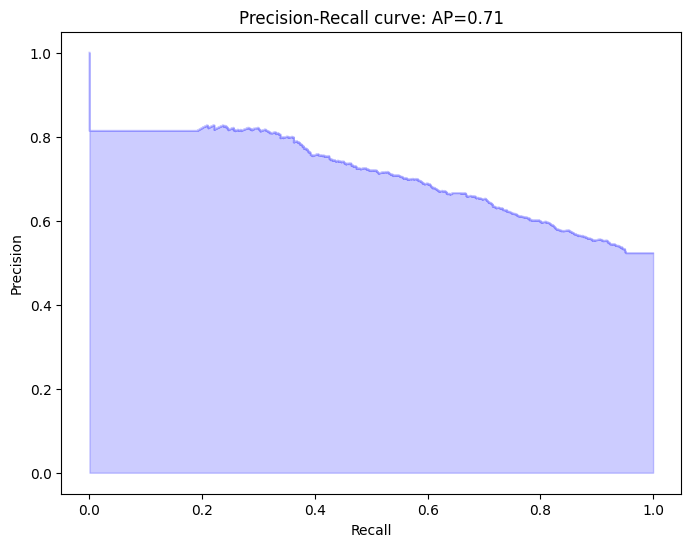

In [117]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

X = customers[features]
y = customers[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Fit the model to the training data
parameters = {"n_neighbors": range(1, 50),
             "weights": ['uniform','distance']} 

gridsearch_knn = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch_knn.fit(X_train, y_train_encoded)

y_pred_knn = gridsearch_knn.predict(X_val)

test_rmse = sqrt(mean_squared_error(y_val_encoded, y_pred_knn))
print(test_rmse)

# Evaluate the KNN model
print("k-Nearest Neighbors (KNN) Classification Report:")
print(classification_report(y_val_encoded, y_pred_knn))


# Calculate the confusion matrix
cm_knn = confusion_matrix(y_val_encoded, y_pred_knn)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gridsearch_knn.classes_, yticklabels=gridsearch_knn.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: KNN Classifier')
plt.show()

# Get predicted probabilities for positive class
y_scores_knn = gridsearch_knn.predict_proba(X_val)[:, 1]

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val_encoded, y_scores_knn)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic: KNN Classifier')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_encoded, y_scores_knn)
avg_precision = average_precision_score(y_val_encoded, y_scores_knn)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(avg_precision))
plt.show()

#### 2.4- Logistic Regression

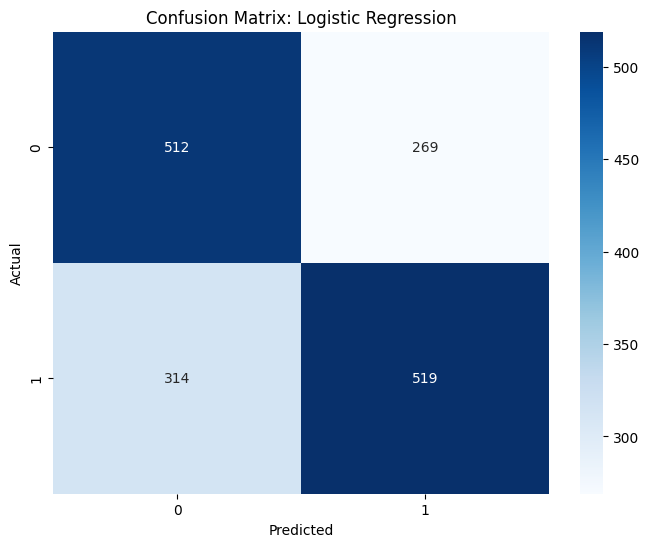

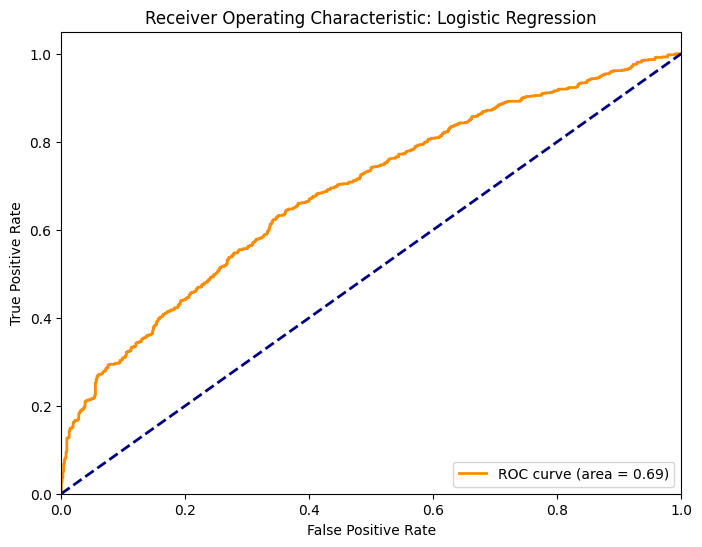

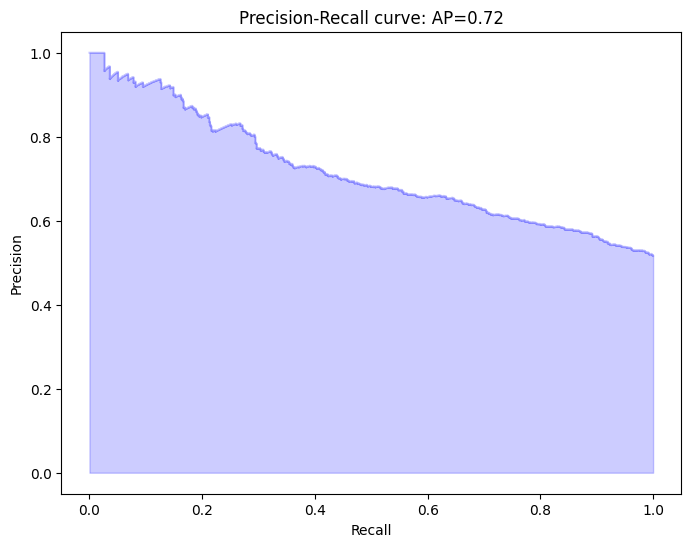

In [118]:
X = customers[features]
y = customers[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize and fit the logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_scaled, y_train_encoded)

# Make predictions on the validation set
y_pred = logreg_model.predict(X_val_scaled)

# Calculate the confusion matrix
cm_logreg = confusion_matrix(y_val_encoded, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

# Get predicted probabilities for positive class
y_scores_logreg = logreg_model.predict_proba(X_val_scaled)[:, 1]

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val_encoded, y_scores_logreg)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic: Logistic Regression')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_encoded, y_scores_logreg)
avg_precision = average_precision_score(y_val_encoded, y_scores_logreg)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(avg_precision))
plt.show()

### 3- Predictions for potencial customers are made based on the Random Forest Classification model that has been obtained.

In [119]:
# Make predictions on the test data
test_predictions = best_rf_model.predict(potencial_customers[features])

# Create a submission dataframe
new_seg = pd.DataFrame({'ID': potencial_customers['ID'], 'Segmentation': test_predictions})

# Save the submission dataframe to a CSV file
new_seg.to_csv('New_Customers_Segmentation.csv', index=False)

### 4- Conclusion

#### The Random Forest Classifier demonstrated a balanced performance in classifying the two classes, HQC and LQC. The classification report reveals that both precision and recall scores are relatively high for both classes. For the HQC class, the classifier achieved a precision of 0.67 and recall of 0.72, indicating that it correctly identified 67% of HQC instances and had a low false positive rate. Similarly, for the LQC class, the precision was 0.72, and the recall was 0.66, implying a balanced trade-off between true positive and false positive rates.

#### The overall accuracy of the Random Forest Classifier was 69%, meaning that it correctly classified 69% of the instances in the validation set. The macro average F1-score, which takes into account both precision and recall, was 0.69, demonstrating a satisfactory balance between the two.

#### The area under the ROC curve (AUC-ROC) value of 0.76 suggests that the Random Forest Classifier performs well in distinguishing between the two classes. An AUC-ROC value closer to 1 indicates a strong separation between classes.

#### The Average Precision (AP) score of 0.78 signifies that the classifier's predictions were reliable, with higher confidence assigned to correct predictions. This indicates that the classifier's ranking of positive instances was consistent and precise.

#### In conclusion, the Random Forest Classifier exhibits a balanced performance in classifying HQC and LQC classes, with satisfactory precision, recall, and F1-score. The strong AUC-ROC and high Average Precision scores underscore the classifier's effectiveness in differentiating between the classes and providing reliable predictions. However, further analysis and potential fine-tuning of the model may be beneficial to enhance its performance even more.